In [ ]:
!nvidia-smi

Wed Mar 16 09:55:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob


In [ ]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
import torch
import torch.nn as nn

"""
Network Architectures
The following are the discriminator and generator architectures
"""
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
# from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import glob
import cv2
import torchvision
avgpool = nn.AdaptiveAvgPool2d((64, 64))
from PIL import Image

In [ ]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


"""
Hyperparameter settings
"""
epochs = 150
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
# G = generator().to(device)
# D = discriminator().to(device)

# G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [ ]:
avgpool = nn.AdaptiveAvgPool2d((64, 64))
class afhqDataset(Dataset):
    def __init__(self, root_dir='/content/drive/MyDrive/wild/'):
        self.root_dir = root_dir
        
        self.img_dir = root_dir + '*.jpg'

    def __len__(self):
        return len(glob.glob(self.img_dir))

    def __getitem__(self, idx):
        image = cv2.imread(glob.glob(self.img_dir)[idx])/255.
        image = torch.Tensor(image)
        image = image.permute(2, 0, 1)
        image = avgpool(image)
        return image

train_set = afhqDataset()
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

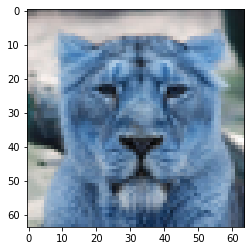

In [ ]:
image = cv2.imread(glob.glob('/content/drive/MyDrive/wild/*')[200])/255.
image = torch.Tensor(image)
image = image.permute(2, 0, 1)
image = avgpool(image)
image = image.permute(1, 2, 0)
plt.imshow(image)
    

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
for epoch in range(epochs):
    for idx, (imgs) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = netD(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 100, 1, 1) - 0.5) / 0.5
        noise = noise.to(device)
#         print(noise.shape)
        fake_inputs = netG(noise)
        fake_outputs = netD(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs.view(-1).unsqueeze(1), fake_outputs.view(-1).unsqueeze(1)), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        optimizerD.zero_grad()
        D_loss.backward()
        optimizerD.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 100, 1, 1)-0.5)/0.5
        noise = noise.to(device)
#         print(noise.shape)
        fake_inputs = netG(noise)
        fake_outputs = netD(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs.view(-1).unsqueeze(1), fake_targets)
        optimizerG.zero_grad()
        G_loss.backward()
        optimizerG.step()

        if idx % 5 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    # if (epoch+1) % 10 == 0:
    #     torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
    #     print('Model saved.')

Epoch 0 Iteration 5: discriminator_loss 0.386 generator_loss 6.846
Epoch 0 Iteration 10: discriminator_loss 0.408 generator_loss 5.731
Epoch 0 Iteration 14: discriminator_loss 0.320 generator_loss 3.635
Epoch 1 Iteration 5: discriminator_loss 0.246 generator_loss 4.006
Epoch 1 Iteration 10: discriminator_loss 0.256 generator_loss 3.970
Epoch 1 Iteration 14: discriminator_loss 0.371 generator_loss 2.606
Epoch 2 Iteration 5: discriminator_loss 0.278 generator_loss 3.212
Epoch 2 Iteration 10: discriminator_loss 0.287 generator_loss 2.946
Epoch 2 Iteration 14: discriminator_loss 0.741 generator_loss 4.507
Epoch 3 Iteration 5: discriminator_loss 0.249 generator_loss 3.698
Epoch 3 Iteration 10: discriminator_loss 0.249 generator_loss 3.934
Epoch 3 Iteration 14: discriminator_loss 0.328 generator_loss 2.905
Epoch 4 Iteration 5: discriminator_loss 0.217 generator_loss 3.534
Epoch 4 Iteration 10: discriminator_loss 0.347 generator_loss 2.875
Epoch 4 Iteration 14: discriminator_loss 0.293 genera

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


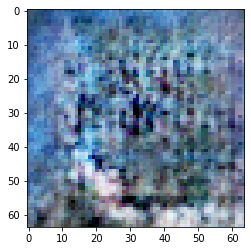

In [ ]:
noise = (torch.rand(real_inputs.shape[0], 100, 1, 1) - 0.5) / 0.5
noise = noise.to(device)
output = netG(noise)
plt.imshow(output[0].permute(1, 2, 0).detach().cpu())